# Text Mining - State of the Union Addresses

In this notebook we will take a look at the text from recent US State of the Union addresses to demonstrate some of our text mining functions.

We will use the Python library `BeautifulSoup` a powerful tool for scraping text from web sites.

[This web site](https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/annual-messages-congress-the-state-the-union) contains links to the text from all SOTU addresses back to George Washington!  For our analysis we will focus on the addresses from the past 50 years.


In [ ]:
pip install beautifulsoup4

In [ ]:
import requests
from bs4 import BeautifulSoup

# URL of the page containing the table of speeches
url = "https://www.presidency.ucsb.edu/documents/presidential-documents-archive-guidebook/annual-messages-congress-the-state-the-union"

# Step 1: Fetch the webpage
response = requests.get(url)
webpage_content = response.content

# Step 2: Parse the webpage content
soup = BeautifulSoup(webpage_content, "html.parser")

# Step 3: Find the table containing speeches
table = soup.find("table")

# Step 4: Extract all speech links from the table
speech_links = []

for a in table.find_all("a", href=True):
    link = a['href']
    # Ensure correct URL format
    full_link = f"{link}"
    speech_links.append(full_link)

# Function to extract speech text from each link
def extract_speech_text(speech_url):
    try:
        speech_response = requests.get(speech_url)
        speech_soup = BeautifulSoup(speech_response.content, "html.parser")
        speech_div = speech_soup.find("div", class_="field-docs-content")

        # Combine all paragraphs to form the full speech
        speech_text = ""
        for p in speech_div.find_all("p"):
            speech_text += p.get_text() + "\n"

        return speech_text
    except Exception as e:
        print(f"Error fetching speech from {speech_url}: {e}")
        return ""

#should be 245 speeches, but we are including the radio interviews present in the table as well

num_recent_speeches = 47 # This goes back to 1977 - Jimmy Carter

total_text = []
count = 1
# Step 5: Iterate through each link and extract speech text
for link in speech_links[:num_recent_speeches]:
    speech_text = extract_speech_text(link)
    if speech_text:
        print(count)
        count += 1
        total_text.append(speech_text)

Want to know which speech is from which President?  [Load this file](https://drive.google.com/uc?download&id=1WyT6g0g4kanujfiy2imuSI35nWuWxPgC).  

In [ ]:
# file upload
from google.colab import files
uploaded = files.upload()


In [ ]:
import pandas as pd

SOTU_index = pd.read_csv("SOTU_index.csv")
SOTU_index.Year

#Text cleaning

This code cleans a list of text by removing punctuation, converting to lowercase, tokenizing, removing stopwords, and lemmatizing each word to its base form for more consistent and meaningful text processing.

In [ ]:
pip install nltk

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk

# Download WordNet data for lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Stopwords list
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text_list):
    cleaned_texts = []
    for text in text_list:
        # Remove punctuation and lowercase the text
        text = re.sub(r'[^\w\s]', '', text.lower())
        # remove numbers
        text = re.sub(r'[\d]', '', text)

        # Tokenize the text
        words = word_tokenize(text)

        # Remove stopwords and lemmatize each word
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

        # Join the words back into a single string
        cleaned_text = ' '.join(words)
        cleaned_texts.append(cleaned_text)

    return cleaned_texts


cleaned_total_text = clean_text(total_text)
#print(cleaned_total_text)


In [ ]:
cleaned_total_text[3]


# Basic Analysis

The code analyzes each speech in total_text by calculating its length, word count, and average syllables per word, then stores these metrics in a DataFrame for easy visualization and comparison.

In [ ]:
nltk.download('cmudict')

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


True

In [ ]:
import pandas as pd
from nltk.corpus import cmudict
from nltk import word_tokenize

# Load the CMU Pronouncing Dictionary for syllable counting
d = cmudict.dict()

# Function to count syllables in a word
def syllable_count(word):
    word = word.lower()
    if word in d:
        return [len(list(y for y in x if y[-1].isdigit())) for x in d[word]][0]
    else:
        # If the word isn't in the CMU dictionary, return a default of 1 syllable
        return 1

# Initialize lists to store analysis results
speech_lengths = []
word_counts = []
average_syllables_per_word = []

# Perform analysis on each speech in total_text
for speech in total_text:
    # Calculate length in characters
    length = len(speech)
    speech_lengths.append(length)

    # Calculate word count
    words = word_tokenize(speech)
    word_count = len(words)
    word_counts.append(word_count)

    # Calculate average syllables per word
    syllables = [syllable_count(word) for word in words]
    if words:
        avg_syllables = sum(syllables) / len(words)
    else:
        avg_syllables = 0
    average_syllables_per_word.append(avg_syllables)

df = pd.DataFrame({
    'Speech Number': range(1, len(total_text) + 1),
    'Length (Characters)': speech_lengths,
    'Word Count': word_counts,
    'Average Syllables per Word': average_syllables_per_word
})

# sort the data by the Year (the original data is not sorted by year)

df['Year']=SOTU_index['Year']
# plot word count in year order
# order the df by Year
df = df.sort_values(by=['Year'])
df.head()

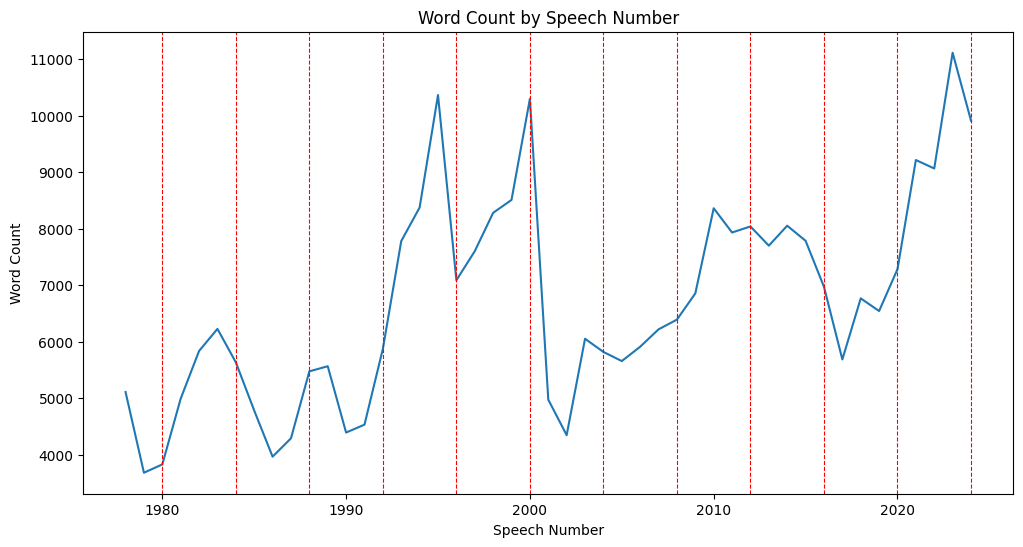

In [ ]:
# prompt: make a plot of the Word Count by time

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with 'Speech Number' and 'Word Count' columns

plt.figure(figsize=(12, 6))
plt.plot(df['Year'], df['Word Count'])
plt.xlabel("Speech Number")
plt.ylabel("Word Count")
plt.title("Word Count by Speech Year")
divisible_by_4_years = df['Year'][df['Year'] % 4 == 0].unique()

# Add vertical lines for each election year
for year in divisible_by_4_years:
    plt.axvline(x=year, color='red', linestyle='--', linewidth=0.8)

plt.show()

# Finding themes in the SOTU speeches

## TFIDF

We will create the TF-IDF matrix of the SOTU to try and bring out the most relevant words from each speech.

In [ ]:
# create a TF/IDF matrix for the speeches

from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer object
# the max_df is key here to avoid words like "state, government, tax, etc that appear in many speeches"
vectorizer = TfidfVectorizer(max_df=0.7,min_df=2) # these values are important!

# Fit the vectorizer to the cleaned text data
tfidf_matrix = vectorizer.fit_transform(cleaned_total_text)

# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Print the shape of the TF-IDF matrix
print(tfidf_matrix.shape)

# You can access the TF-IDF values for each document and term
# For example, to get the TF-IDF values for the first document:
#print(tfidf_matrix[0])


(47, 5561)


In [ ]:
# prompt: find the actual words that have the highest TF-IDF value for a given speech

year = 2002

idx = df[df['Year'] == year].index[0]

# Get the TF-IDF values for that year's document
first_document_tfidf = tfidf_matrix[idx]

topn = 20

# Get the indices of the top 10 TF-IDF values
top_indices = first_document_tfidf.tocoo().col[first_document_tfidf.tocoo().data.argsort()[-topn:][::-1]]

# Get the actual words corresponding to the top indices
top_words = [feature_names[i] for i in top_indices]

# Print the top words
print(top_words)


['terrorist', 'terror', 'regime', 'afghanistan', 'camp', 'homeland', 'corp', 'islamic', 'september', 'evil', 'enemy', 'danger', 'destruction', 'culture', 'unique', 'hatred', 'mass', 'depend', 'creed', 'attendant']


## Topic Modelling - LDA

Helps to find common themes across speeches

In [ ]:
!pip install gensim nltk scikit-learn


In [ ]:
from gensim import corpora
from gensim.models import LdaModel
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
import re
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

The LDA functions need the data in a slightly different format, so lets do our cleaning once again...

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_for_lda(text):
    # Remove punctuation and numbers
    text = re.sub(r'[\d]', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize and remove stopwords
    tokens = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return tokens

preprocessed_texts = [preprocess_for_lda(doc) for doc in total_text]


In [ ]:
## Create the TF-IDF Vectorized version again

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=0.7,min_df=2)
tfidf_matrix = vectorizer.fit_transform([" ".join(text) for text in preprocessed_texts])  # Note: Joining tokens back


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from gensim import matutils, corpora

num_topics=20

dictionary = corpora.Dictionary(preprocessed_texts)
corpus_tfidf = matutils.Sparse2Corpus(tfidf_matrix.transpose())
id2word_tfidf = dict((v, k) for k, v in vectorizer.vocabulary_.items())
lda_model_tfidf = LdaModel(corpus_tfidf, id2word=id2word_tfidf, num_topics=num_topics, passes=10, random_state=13)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for idx, topic in lda_model_tfidf.print_topics(-1,num_words=20):
    print(f"Topic {idx + 1}: {topic}")


Topic 1: 0.000*"preschool" + 0.000*"preserving" + 0.000*"practice" + 0.000*"presidential" + 0.000*"presidents" + 0.000*"preserve" + 0.000*"presidency" + 0.000*"prescription" + 0.000*"pray" + 0.000*"preparing" + 0.000*"prepared" + 0.000*"prepare" + 0.000*"premiums" + 0.000*"pregnancy" + 0.000*"preexisting" + 0.000*"predicted" + 0.000*"precious" + 0.000*"presence" + 0.000*"preservation" + 0.000*"present"
Topic 2: 0.001*"lending" + 0.001*"banks" + 0.000*"renewable" + 0.000*"buy" + 0.000*"receive" + 0.000*"loans" + 0.000*"lay" + 0.000*"vote" + 0.000*"crisis" + 0.000*"arrived" + 0.000*"breaks" + 0.000*"worse" + 0.000*"recovery" + 0.000*"wait" + 0.000*"afford" + 0.000*"college" + 0.000*"govern" + 0.000*"entrepreneurs" + 0.000*"invest" + 0.000*"concern"
Topic 3: 0.009*"iraq" + 0.007*"terrorists" + 0.006*"got" + 0.006*"terror" + 0.005*"iraqi" + 0.005*"al" + 0.004*"qaida" + 0.004*"terrorist" + 0.004*"liberty" + 0.004*"retirement" + 0.004*"ill" + 0.004*"saddam" + 0.003*"given" + 0.003*"effective

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The methods that work with long texts like SOTU wont necessarily work so well with shorter ones like tweets...it will probably take a lot of trial and error!

# Named Entity Recognition

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Select a speech from your total_text list
year = 1997
idx = df[df['Year'] == year].index[0]
speech_to_analyze = total_text[idx]  # For example, the first speech

# Apply NER to the speech
doc = nlp(speech_to_analyze)

#Print the named entities
for ent in doc.ents:
    print(f"{ent.text} - {ent.label_}")



In [ ]:

persons = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
persons

In [ ]:
pos_tags = [(token.text, token.pos_) for token in doc]

pos_tags[1:30]

# Sentiment analysis

using `AFINN`


In [ ]:
!pip install afinn

In [ ]:
# use AFINN

from afinn import Afinn

afinn = Afinn()

sentiment_scores = []
for speech in cleaned_total_text:
    score = afinn.score(speech)
    sentiment_scores.append(score)

# Print sentiment scores for each speech
# for i, score in enumerate(sentiment_scores):
#     print(f"Speech {i + 1}: Sentiment Score = {score}")

# Plot sentiment scores over time
import matplotlib.pyplot as plt
plt.plot(SOTU_index['Year'], sentiment_scores, 'o')  # Use 'o-' for points and lines
plt.xlabel("Year")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis of State of the Union Addresses (AFINN)")
for year in divisible_by_4_years:
    plt.axvline(x=year, color='red', linestyle='--', linewidth=0.8)
plt.show()